## Depth of upwelling in two-canyon runs

* All experiments have 3 runs to get a mean curve (except aug01, I eliminated run that does weird things).
* Parameters can be found on google drive sheet lab_speadsheets/exp_list

Using calibration 9th Aug (closest to exeriments) to check how it affects density change in the canyon heads.


In [1]:
import cmocean as cmo
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np
from numpy.polynomial import polynomial as P
import os
import pandas as pd
#import seaborn as sns
import scipy.io as sio
import seaborn as sns
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('/ocean/kramosmu/MultipleCanyons/lab/Conduino/scripts')
import profiler_tools as ptools
import conduino_tools as ctools


In [2]:
sns.set_style('whitegrid')
sns.set_context('notebook')

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
def plot_uprofile(ax, col='0.8'):
    ax.axvline(15, color=col, linestyle=':')
    ax.axvline(21.0+15, color=col, linestyle=':')
    ax.axvline(71.0+15, color=col, linestyle=':')
        
def plot_forcing(ax, file, f0, f1, f2, t0, t1):
    '''ax: axes to plot figure on
       file: experiment file to extract time
       f0: Angular velocity of the table during spin up
       f1: f at max forcing
       f2: f to avoid spin down
       t0: time to get to f1
       t1: time to get to f2'''
    mat = sio.loadmat(file, squeeze_me=True)
    time = mat['time']
    t2 = np.round(np.max(time),2) # s

    ax0.text(0.3,0.3,r'$\Delta f_1=$%1.2f rad/s, $\Delta t_1=$%1.1f s' %((f1-f0),t0), transform=ax0.transAxes)
    ax0.text(0.5,0.7,r'$\Delta f_2=$%1.2f rad/s, $\Delta t_2=$%1.1f s' %((f2-f1),(t1-t0)), transform=ax0.transAxes)

    ax0.plot([0,t0,t1,t2],[f0,f1,f2,f2], 'g-')
    ax0.set_ylabel('f table / rad s$^{-1}$')
    ax0.set_xlabel('time / s')

In [5]:
# Information for all runs is stored in experiment_dictionaries.py
lib_path = os.path.abspath('/ocean/kramosmu/MultipleCanyons/lab/Conduino/scripts') # Add absolute path to my python scripts
sys.path.append(lib_path)

import experiment_dictionaries as exdic

In [6]:
exp_dicts = [exdic.T01,exdic.T02,exdic.T03,exdic.T04,exdic.T05,
             exdic.T06,exdic.T07,exdic.T08,exdic.T09,exdic.T10,
             exdic.T11,exdic.T12, exdic.DYE02]
exp_num = len(exp_dicts) # number of experiment dictionaries

colors = ['teal','darkorange','yellowgreen', 'tan']
exp_Norder = [exdic.T02,exdic.T03,exdic.T04,exdic.T05,exdic.T01,
             exdic.DYE02,exdic.T12,exdic.T11,exdic.T07,exdic.T06,
             exdic.T08,exdic.T10, exdic.T09]

### Plots arranged by $N_{shelf}$ and $f$

Plotting mean upstream, mean downstream and mean difference filtered using salish sea filter_timeseries with window win = int(T/dt) where T is the inertial period and dt the time between conduino samples.  

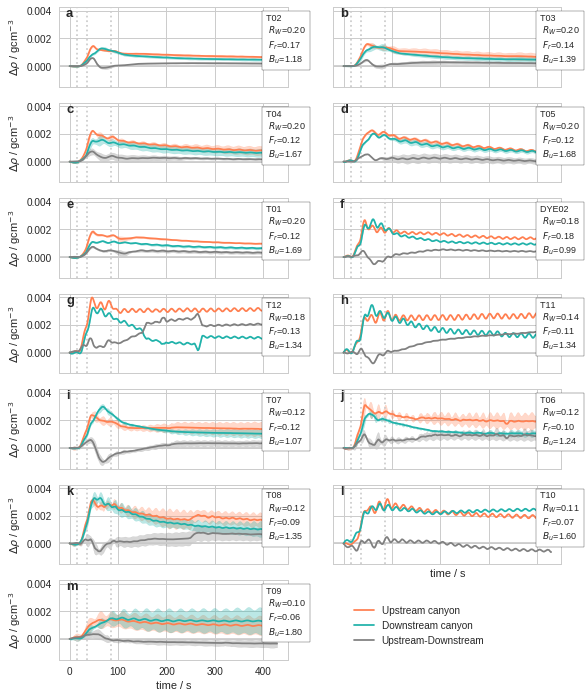

In [7]:
fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7),(ax8,ax9),(ax10,ax11),(ax12,ax13)) = plt.subplots(7, 2, figsize=(9,12), 
                                                                                    sharey=True, sharex=True)

axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]
filepath =  exdic.T01['dir']+ exdic.T01['run_files'][0]
mat = sio.loadmat(filepath, squeeze_me=True)
time = mat['time']
panel_labels = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
exp_names = ['T02','T03', 'T04', 'T05', 'T01','DYE02', 'T12', 'T11', 
            'T07', 'T06','T08', 'T10',  'T09']
rho0=998.5
g = 9.81

for exp, kk, ax,pan_lab, name in zip(exp_Norder, range(exp_num), axs, panel_labels, exp_names):
    probe1 = np.zeros((len(time),len(exp['run_files'])))
    probe2 = np.zeros((len(time),len(exp['run_files'])))
    probe_dif = np.zeros((len(time),len(exp['run_files'])))
    
    Navg = np.ones((4))*np.nan
    for ii,col in zip(range(len(exp['run_files'])),colors):
         
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        inertial_period = 1/((exp["fo"])/(2*np.pi))
        win = int(inertial_period/dt)
        
        probe1[:,ii] = ctools.filter_timeseries((dens1-dens1[0]),winlen=win)
        probe2[:,ii] = ctools.filter_timeseries((dens2-dens2[0]),winlen=win)
        probe_dif[:,ii] = ctools.filter_timeseries(((dens1-dens1[0])-(dens2-dens2[0])),winlen=win)
        Navg[ii] = ((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5 
    
    N = np.nanmean(Navg)
    W = 5 # W at half length (cm)
    Bu = (N*exp["hsb"])/(exp["fo"]*W)
    Rw = (exp["U"])/(exp["fo"]*W)
    Fr = exp["U"]/(N*exp["hsb"])
    ax.axhline(0, color='0.8')
    plot_uprofile(ax)
    
    ax.text(0.905,0.3,'%s \n $R_W$=%1.2f \n $F_r$=%1.2f \n $B_u$=%1.2f' \
            %(name,Rw,Fr,Bu), transform=ax.transAxes,fontsize=9,
            bbox=dict(facecolor='white', alpha=1) )
    avg1 = np.nanmean(probe1, axis=1)
    std1 = np.nanstd(probe1, axis=1)
    ax.plot(time, avg1 ,'-',color='coral', label='Upstream canyon')
    ax.fill_between(time, avg1+std1, avg1-std1,color='coral', alpha=0.3)
    
    avg2 = np.nanmean(probe2, axis=1)
    std2 = np.nanstd(probe2, axis=1)
    ax.plot(time, avg2 ,'-',color='lightseagreen', label='Downstream canyon')
    ax.fill_between(time, avg2+std2, avg2-std2,color='lightseagreen', alpha=0.3)
    
    avg3 = np.nanmean(probe_dif, axis=1)
    std3 = np.nanstd(probe_dif, axis=1)
    ax.plot(time, avg3 ,'-',color='0.5', label='Upstream-Downstream')
    ax.fill_between(time, avg3+std3, avg3-std3,color='0.5', alpha=0.3)
    
    ax.text(0.03,0.88, pan_lab, fontweight='bold', fontsize=13, transform=ax.transAxes)

ax13.axis("off")
for ax in [ax0,ax2,ax4,ax6,ax8, ax10,ax12]:
    ax.set_ylabel(r'$\Delta \rho$ / gcm$^{-3}$')
ax12.set_xlabel('time / s')
ax11.set_xlabel('time / s')
ax12.legend(bbox_to_anchor=(1.25,0.8))
plt.savefig('figures/twocanyon_timeseries.pdf', format='pdf', transparent=False, bbox_inches='tight')

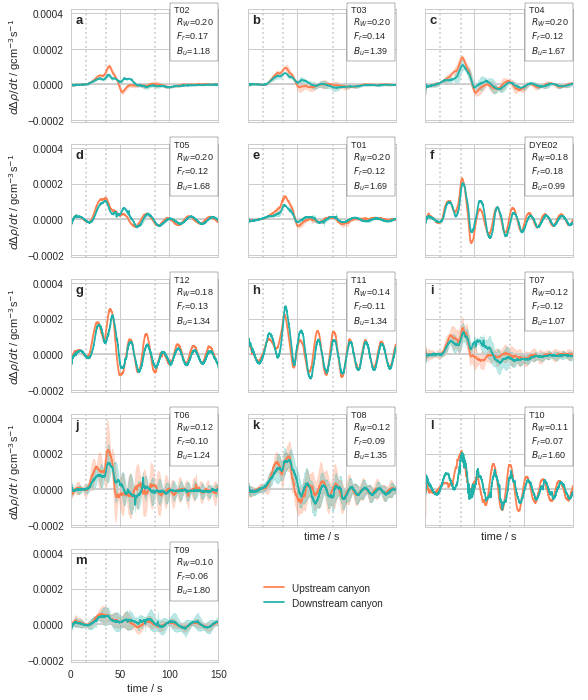

In [50]:
fig, ((ax0,ax1,ax2),(ax3,ax4,ax5),(ax6,ax7,ax8),(ax9,ax10,ax11),(ax12,ax13,ax14)) = plt.subplots(5, 3, figsize=(9,12), 
                                                                                    sharey=True, sharex=True)
axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]
filepath =  exdic.T01['dir']+ exdic.T01['run_files'][0]
mat = sio.loadmat(filepath, squeeze_me=True)
time = mat['time']
panel_labels = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
exp_names = ['T02','T03', 'T04', 'T05', 'T01','DYE02', 'T12', 'T11', 
            'T07', 'T06','T08', 'T10',  'T09']
rho0=998.5
g = 9.81

for exp, kk, ax,pan_lab, name in zip(exp_Norder, range(exp_num), axs, panel_labels, exp_names):
    probe1 = np.zeros((len(time)-2,len(exp['run_files'])))
    probe2 = np.zeros((len(time)-2,len(exp['run_files'])))
    probe_dif = np.zeros((len(time)-2,len(exp['run_files'])))
    
    Navg = np.ones((4))*np.nan
    for ii,col in zip(range(len(exp['run_files'])),colors):
         
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        inertial_period = 1/((exp["fo"])/(2*np.pi))
        win = int(inertial_period/dt)
        
        meas1 = ctools.filter_timeseries((dens1-dens1[0]),winlen=win)
        probe1[:,ii] = (meas1[2:]-meas1[:-2])/(time[2:]-time[:-2])
        meas2 = ctools.filter_timeseries((dens2-dens2[0]),winlen=win)
        probe2[:,ii] = (meas2[2:]-meas2[:-2])/(time[2:]-time[:-2])
        #probe_dif[:,ii] = probe1[:,ii]-probe2[:,ii]
        
        Navg[ii] = ((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5 
    
    N = np.nanmean(Navg)
    W = 5 # W at half length (cm)
    Bu = (N*exp["hsb"])/(exp["fo"]*W)
    Rw = (exp["U"])/(exp["fo"]*W)
    Fr = exp["U"]/(N*exp["hsb"])
    ax.axhline(0, color='0.8')
    plot_uprofile(ax)
    
    ax.text(0.7,0.6,'%s \n $R_W$=%1.2f \n $F_r$=%1.2f \n $B_u$=%1.2f' \
            %(name,Rw,Fr,Bu), transform=ax.transAxes,fontsize=9,
            bbox=dict(facecolor='white', alpha=1) )
    avg1 = np.nanmean(probe1, axis=1)
    
    std1 = np.nanstd(probe1, axis=1)
    ax.plot(time[1:-1], avg1 ,'-',color='coral', label='Upstream canyon')
    ax.fill_between(time[1:-1], avg1+std1, avg1-std1,color='coral', alpha=0.3)
    
    avg2 = np.nanmean(probe2, axis=1)
    std2 = np.nanstd(probe2, axis=1)
    ax.plot(time[1:-1], avg2 ,'-',color='lightseagreen', label='Downstream canyon')
    ax.fill_between(time[1:-1], avg2+std2, avg2-std2,color='lightseagreen', alpha=0.3)
    
    #avg3 = np.nanmean(probe_dif, axis=1)
    #std3 = np.nanstd(probe_dif, axis=1)
    #ax.plot(time[1:-1], avg3 ,'-',color='0.5', label=r'${\frac{d\Delta\rho}{dt}}_{upstream}-{\frac{d\Delta\rho}{dt}}_{downstream}$')
    #ax.fill_between(time[1:-1], avg3+std3, avg3-std3,color='0.5', alpha=0.3)
    
    ax.text(0.03,0.88, pan_lab, fontweight='bold', fontsize=13, transform=ax.transAxes)

ax1.set_xlim(0,150)
ax13.axis("off")
ax14.axis("off")
for ax in [ax0,ax3,ax6,ax9]:
    ax.set_ylabel(r'$d\Delta \rho/dt$ / gcm$^{-3}$s$^{-1}$')
ax12.set_xlabel('time / s')
ax11.set_xlabel('time / s')
ax10.set_xlabel('time / s')
ax12.legend(bbox_to_anchor=(1.25,0.4))
plt.savefig('figures/twocanyon_timeseries_derivative.pdf', format='pdf', transparent=False, bbox_inches='tight')

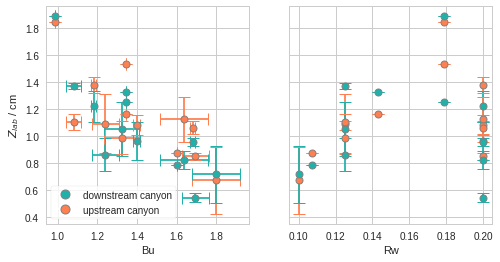

In [19]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)

rho0=998.5
g = 9.81

for exp, kk in zip(exp_dicts, range(exp_num)):
    delta_rho1 = np.zeros(len(exp['run_files']))
    delta_rho2 = np.zeros(len(exp['run_files']))
    N = np.ones(len(exp['run_files']))*np.nan
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        inertial_period = 1/((exp["fo"])/(2*np.pi))
        win = int(inertial_period/dt)
        
        delta_rho2[ii] = 1000*(np.max(ctools.filter_timeseries(dens2[0:2400]-dens2[0],winlen=win))) # kg/m^3
        delta_rho1[ii] = 1000*(np.max(ctools.filter_timeseries(dens1[0:2400]-dens1[0],winlen=win))) # kg/m^3
        if np.isnan(exp["rho_sb"][ii])==True:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii-1]-1000*exp["rho_top"][ii-1])/(exp["hsb"]*0.01)))**0.5
        else:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
    Z1 = np.nanmean(100*(g/rho0)*(delta_rho1/N**2)) #cm
    Z2 = np.nanmean(100*(g/rho0)*(delta_rho2/N**2)) #cm
    std1 = np.nanstd(100*(g/rho0)*(delta_rho1/N**2)) #cm
    std2 = np.nanstd(100*(g/rho0)*(delta_rho2/N**2)) #cm
    W = 5 # cm
    Bu = np.nanmean(N*exp["hsb"]/(exp["fo"]*W))
    stdBu = np.nanstd(N*exp["hsb"]/(exp["fo"]*W))
    Rw = exp["U"]/(exp["fo"]*W)

    sca = ax1.errorbar(Bu,Z1,yerr=std1,xerr=stdBu,
                       marker='o',color='coral', 
                       markeredgecolor='0.5', 
                       markeredgewidth=1,capsize=6) 
    sca = ax1.errorbar(Bu,Z2,yerr=std2,xerr=stdBu,
                       marker='o',color='lightseagreen', 
                       markeredgecolor='0.5', 
                       markeredgewidth=1,capsize=6) 
    sca2 = ax2.errorbar(Rw,Z1,yerr=std1,
                        marker='o',color='coral',
                        markeredgecolor='0.5',
                        markeredgewidth=1,capsize=6) 
    sca2 = ax2.errorbar(Rw,Z2,yerr=std2,
                        marker='o',color='lightseagreen', 
                        markeredgecolor='0.5', 
                        markeredgewidth=1,capsize=6) 

        
legend_elements = [Line2D([0], [0], marker='o', color='w', label='downstream canyon',
                          markerfacecolor='lightseagreen',markeredgecolor='0.5',markeredgewidth=1,
                          markersize=9),
                   Line2D([0], [0], marker='o', color='w', label='upstream canyon',
                          markerfacecolor='coral',markeredgecolor='0.5',markeredgewidth=1,
                          markersize=9),
                   ]
ax1.legend(handles=legend_elements, loc=3,frameon=True )
ax1.set_xlabel('Bu')
ax2.set_xlabel('Rw')
ax1.set_ylabel(r'$Z_{lab}$ / cm')
plt.savefig('figures/Z_Ro_Rw_twocan_std.eps', format='eps', transparent=False, bbox_inches='tight')

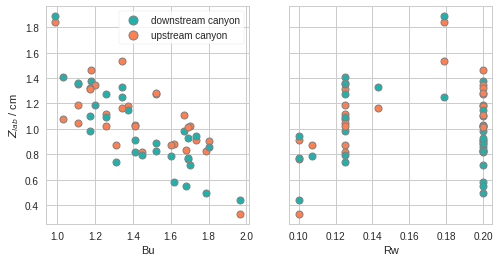

In [48]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)

rho0=998.5
g = 9.81

for exp, kk in zip(exp_dicts, range(exp_num)):
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        W = 5 # cm
        if np.isnan(exp["rho_sb"][ii])==True:
            N =((g/rho0)*((1000*exp["rho_sb"][ii-1]-1000*exp["rho_top"][ii-1])/(exp["hsb"]*0.01)))**0.5
        else:
            N =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
        
        Bu = N*exp["hsb"]/(exp["fo"]*W)
        Rw = exp["U"]/(exp["fo"]*W)
        
        inertial_period = 1/((exp["fo"])/(2*np.pi))
        win = int(inertial_period/dt)
        delta_rho2 = 1000*(np.max(ctools.filter_timeseries(dens2[0:2400]-dens2[0],winlen=win))) # kg/m^3
        delta_rho1 = 1000*(np.max(ctools.filter_timeseries(dens1[0:2400]-dens1[0],winlen=win))) # kg/m^3
        
        Z1 = 100*(g/rho0)*(delta_rho1/N**2) #cm
        Z2 = 100*(g/rho0)*(delta_rho2/N**2) #cm
        
        sca = ax1.plot(Bu,Z1,
                       'o',color='coral', markeredgecolor='0.5', markeredgewidth=1) 
        
        sca = ax1.plot(Bu,Z2,
                       'o',color='lightseagreen', markeredgecolor='0.5', markeredgewidth=1) 
        
        sca2 = ax2.plot(Rw,Z1,
                        'o',color='coral', markeredgecolor='0.5', markeredgewidth=1) 
        sca2 = ax2.plot(Rw,Z2,
                        'o',color='lightseagreen', markeredgecolor='0.5', markeredgewidth=1) 

        
legend_elements = [Line2D([0], [0], marker='o', color='w', label='downstream canyon',
                          markerfacecolor='lightseagreen',markeredgecolor='0.5',markeredgewidth=1,
                          markersize=9),
                   Line2D([0], [0], marker='o', color='w', label='upstream canyon',
                          markerfacecolor='coral',markeredgecolor='0.5',markeredgewidth=1,
                          markersize=9),
                   ]
ax1.legend(handles=legend_elements, loc=0,frameon=True )
ax1.set_xlabel('Bu')
ax2.set_xlabel('Rw')
ax1.set_ylabel(r'$Z_{lab}$ / cm')
plt.savefig('figures/Z_Ro_Rw_twocan.eps', format='eps', transparent=False, bbox_inches='tight')

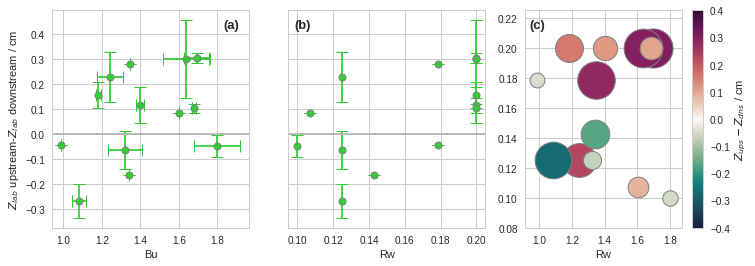

In [42]:
fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
ax1.axhline(0, color='0.7')
ax2.axhline(0, color='0.7')

rho0 = 998.5
g = 9.81
W = 0.05 # m
L = 0.12 # m

Z_list1 = []
Z_list2 = []
Z_HA2013_list = []

for exp, kk in zip(exp_dicts, range(exp_num)):
    Z1 = np.zeros(len(exp['run_files']))
    Z2 = np.zeros(len(exp['run_files']))
    N = np.ones(len(exp['run_files']))*np.nan
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        inertial_period = 1/((exp["fo"])/(2*np.pi))
        win = int(inertial_period/dt)
        
        delta_rho2 = 1000*(np.max(ctools.filter_timeseries(dens2[0:2400]-dens2[0],winlen=win))) # kg/m^3
        delta_rho1 = 1000*(np.max(ctools.filter_timeseries(dens1[0:2400]-dens1[0],winlen=win))) # kg/m^3
        if np.isnan(exp["rho_sb"][ii])==True:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii-1]-1000*exp["rho_top"][ii-1])/(exp["hsb"]*0.01)))**0.5
        else:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
    
        Z1[ii] = (100*(g/rho0)*(delta_rho1/N[ii]**2)) #cm
        Z2[ii] = (100*(g/rho0)*(delta_rho2/N[ii]**2)) #cm
    
    W = 5 # cm
    Bu = np.nanmean(N*exp["hsb"]/(exp["fo"]*W))
    stdBu = np.nanstd(N*exp["hsb"]/(exp["fo"]*W))
    Rw = exp["U"]/(exp["fo"]*W)
    Zdif = np.nanmean(Z1-Z2)
    std_dif = np.nanstd(Z1-Z2)
    sca = ax1.errorbar(Bu,Zdif,yerr=std_dif,xerr=stdBu,
                       marker='o',color='limegreen',
                       markeredgecolor='0.5', markeredgewidth=1,capsize=6) 
          
    sca2 = ax2.errorbar(Rw,Zdif,yerr=std_dif,
                        marker='o',color='limegreen',
                        markeredgecolor='0.5', markeredgewidth=1,capsize=6)
    sca3 = ax3.scatter(Bu,Rw,
                       s=5000*(abs(Zdif)),
                       c=Zdif,
                       cmap = cmo.cm.curl,
                       marker = 'o',
                       vmax=0.4,
                       vmin=-0.4,
                       edgecolors='0.5',
                       linewidth=1, 
                       ) 
cb = plt.colorbar(sca3)
cb.set_label(r'$Z_{ups}-Z_{dns}$ / cm')
ax3.set_ylim(0.08,0.225)
ax1.set_xlabel('Bu')
ax2.set_xlabel('Rw')
ax2.set_yticklabels([])
ax3.set_xlabel('Bu')
ax3.set_xlabel('Rw')

ax1.set_ylabel(r'$Z_{lab}$ upstream-$Z_{lab}$ downstream / cm')
ax1.text(0.87,0.92,'(a)', fontweight='bold', fontsize=13, transform=ax1.transAxes)
ax2.text(0.03,0.92,'(b)', fontweight='bold', fontsize=13, transform=ax2.transAxes)
ax3.text(0.03,0.92,'(c)', fontweight='bold', fontsize=13, transform=ax3.transAxes)
plt.savefig('figures/difference_Z_Ro_Rw_twocan_std.pdf', format='pdf', transparent=False, bbox_inches='tight')

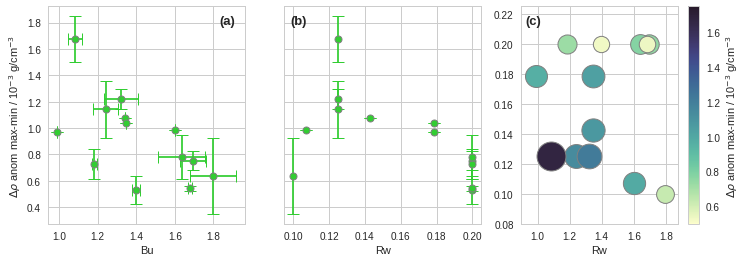

In [47]:
fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

rho0 = 998.5
g = 9.81
W = 0.05 # m
L = 0.12 # m

for exp, kk in zip(exp_dicts, range(exp_num)):
    delta_rho_maxmin = np.zeros(len(exp['run_files']))
    N = np.ones(len(exp['run_files']))*np.nan
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        inertial_period = 1/((exp["fo"])/(2*np.pi))
        win = int(inertial_period/dt)
        
        delta_rho = 1000*(ctools.filter_timeseries((dens2[0:2400]-dens2[0])-(dens1[0:2400]-dens1[0]),winlen=win)) # kg/m^3
        delta_rho_maxmin[ii] = np.max(delta_rho)-np.min(delta_rho)
        
        if np.isnan(exp["rho_sb"][ii])==True:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii-1]-1000*exp["rho_top"][ii-1])/(exp["hsb"]*0.01)))**0.5
        else:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
    
    W = 5 # cm
    Bu = np.nanmean(N*exp["hsb"]/(exp["fo"]*W))
    stdBu = np.nanstd(N*exp["hsb"]/(exp["fo"]*W))
    Rw = exp["U"]/(exp["fo"]*W)
    delta_rho_mean = np.nanmean(delta_rho_maxmin)
    delta_rho_std = np.nanstd(delta_rho_maxmin)
    
    sca = ax1.errorbar(Bu,delta_rho_mean,yerr=delta_rho_std,xerr=stdBu,
                       marker='o',color='limegreen',
                       markeredgecolor='0.5', markeredgewidth=1,capsize=6) 
          
    sca2 = ax2.errorbar(Rw,delta_rho_mean,yerr=delta_rho_std,
                        marker='o',color='limegreen',
                        markeredgecolor='0.5', markeredgewidth=1,capsize=6)
    sca3 = ax3.scatter(Bu,Rw,
                       s=500*(abs(delta_rho_mean)),
                       c=delta_rho_mean,
                       cmap = cmo.cm.deep,
                       marker = 'o',
                       vmax=1.75,
                       vmin=0.5,
                       edgecolors='0.5',
                       linewidth=1, 
                       ) 
cb = plt.colorbar(sca3)
cb.set_label(r'$\Delta \rho$ anom max-min / 10$^{-3}$ g/cm$^{-3}$')
ax3.set_ylim(0.08,0.225)
ax1.set_xlabel('Bu')
ax2.set_xlabel('Rw')
ax2.set_yticklabels([])
ax3.set_xlabel('Bu')
ax3.set_xlabel('Rw')

ax1.set_ylabel(r'$\Delta \rho$ anom max-min / 10$^{-3}$ g/cm$^{-3}$')
ax1.text(0.87,0.92,'(a)', fontweight='bold', fontsize=13, transform=ax1.transAxes)
ax2.text(0.03,0.92,'(b)', fontweight='bold', fontsize=13, transform=ax2.transAxes)
ax3.text(0.03,0.92,'(c)', fontweight='bold', fontsize=13, transform=ax3.transAxes)
plt.savefig('figures/difference_max_min_Ro_Rw_twocan_std.pdf', format='pdf', transparent=False, bbox_inches='tight')

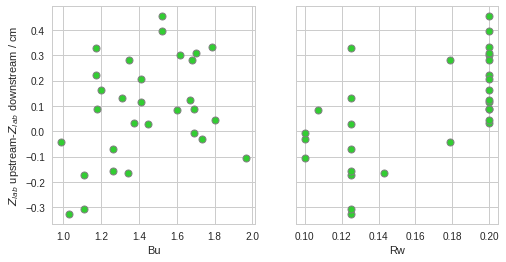

In [9]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)

rho0=998.5
g = 9.81

for exp, kk in zip(exp_dicts, range(exp_num)):
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        W = 5 # cm
        if np.isnan(exp["rho_sb"][ii])==True:
            N =((g/rho0)*((1000*exp["rho_sb"][ii-1]-1000*exp["rho_top"][ii-1])/(exp["hsb"]*0.01)))**0.5
        else:
            N =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
        
        Bu = N*exp["hsb"]/(exp["fo"]*W)
        Rw = exp["U"]/(exp["fo"]*W)
        
        inertial_period = 1/((exp["fo"])/(2*np.pi))
        win = int(inertial_period/dt)
        delta_rho2 = 1000*(np.max(ctools.filter_timeseries(dens2[0:2400]-dens2[0],winlen=win))) # kg/m^3
        delta_rho1 = 1000*(np.max(ctools.filter_timeseries(dens1[0:2400]-dens1[0],winlen=win))) # kg/m^3
        
        Z1 = 100*(g/rho0)*(delta_rho1/N**2) #cm
        Z2 = 100*(g/rho0)*(delta_rho2/N**2) #cm
        
        sca = ax1.plot(Bu,Z1-Z2,
                       'o',color='limegreen', markeredgecolor='0.5', markeredgewidth=1) 
          
        sca2 = ax2.plot(Rw,Z1-Z2,
                        'o',color='limegreen', markeredgecolor='0.5', markeredgewidth=1) 
        
ax1.set_xlabel('Bu')
ax2.set_xlabel('Rw')
ax1.set_ylabel(r'$Z_{lab}$ upstream-$Z_{lab}$ downstream / cm')
plt.savefig('figures/difference_Z_Ro_Rw_twocan.eps', format='eps', transparent=False, bbox_inches='tight')

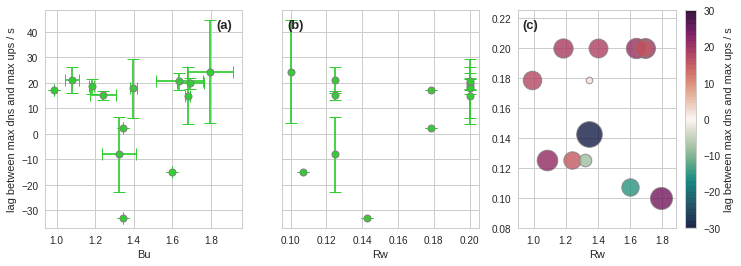

In [57]:
fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

rho0 = 998.5
g = 9.81
W = 0.05 # m
L = 0.12 # m

for exp, kk in zip(exp_dicts, range(exp_num)):
    lag = np.zeros(len(exp['run_files']))
    N = np.ones(len(exp['run_files']))*np.nan
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        inertial_period = 1/((exp["fo"])/(2*np.pi))
        win = int(inertial_period/dt)
        
        rho1 = 1000*(ctools.filter_timeseries((dens1[0:2400]-dens1[0]),winlen=win)) # kg/m^3
        rho2 = 1000*(ctools.filter_timeseries((dens2[0:2400]-dens2[0]),winlen=win)) # kg/m^3
        
        lag[ii] = time[np.argmax(rho2)]-time[np.argmax(rho1)]
        
        if np.isnan(exp["rho_sb"][ii])==True:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii-1]-1000*exp["rho_top"][ii-1])/(exp["hsb"]*0.01)))**0.5
        else:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
    
    W = 5 # cm
    Bu = np.nanmean(N*exp["hsb"]/(exp["fo"]*W))
    stdBu = np.nanstd(N*exp["hsb"]/(exp["fo"]*W))
    Rw = exp["U"]/(exp["fo"]*W)
    lag_mean = np.nanmean(lag)
    lag_std = np.nanstd(lag)
    sca = ax1.errorbar(Bu,lag_mean,yerr=lag_std,xerr=stdBu,
                       marker='o',color='limegreen',
                       markeredgecolor='0.5', markeredgewidth=1,capsize=6) 
          
    sca2 = ax2.errorbar(Rw,lag_mean,yerr=lag_std,
                        marker='o',color='limegreen',
                        markeredgecolor='0.5', markeredgewidth=1,capsize=6)
    sca3 = ax3.scatter(Bu,Rw,
                       s=20*(abs(lag_mean)),
                       c=lag_mean,
                       cmap = cmo.cm.curl,
                       marker = 'o',
                       vmax=30,
                       vmin=-30,
                       edgecolors='0.5',
                       linewidth=1,
                       alpha=0.8
                       ) 
cb = plt.colorbar(sca3)
cb.set_label(r'lag between max dns and max ups / s')
ax3.set_ylim(0.08,0.225)
ax1.set_xlabel('Bu')
ax2.set_xlabel('Rw')
ax2.set_yticklabels([])
ax3.set_xlabel('Bu')
ax3.set_xlabel('Rw')

ax1.set_ylabel(r'lag between max dns and max ups / s')
ax1.text(0.87,0.92,'(a)', fontweight='bold', fontsize=13, transform=ax1.transAxes)
ax2.text(0.03,0.92,'(b)', fontweight='bold', fontsize=13, transform=ax2.transAxes)
ax3.text(0.03,0.92,'(c)', fontweight='bold', fontsize=13, transform=ax3.transAxes)
plt.savefig('figures/lag_Ro_Rw_twocan_std.pdf', format='pdf', transparent=False, bbox_inches='tight')

the rmse1 is 0.154193
the rmse2 is 0.264457


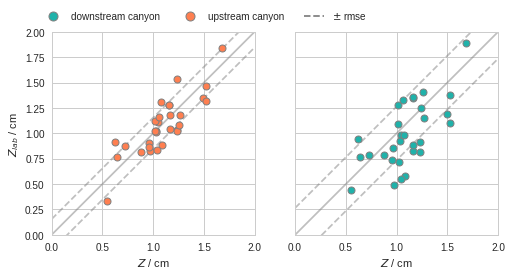

In [10]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)

rho0 = 998.5
g = 9.81
W = 0.05 # m
L = 0.12 # m

Z_list1 = []
Z_list2 = []
Z_HA2013_list = []


for exp, kk in zip(exp_dicts, range(exp_num)):
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        
        if np.isnan(exp["rho_sb"][ii])==True:
            N =((g/rho0)*((1000*exp["rho_sb"][ii-1]-1000*exp["rho_top"][ii-1])/(exp["hsb"]*0.01)))**0.5
        else:
            N =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
        
        f = exp["fo"] # rad/s
        U = exp["U"]/100 # m/s
        Hs = exp["hsb"]/100 # m
        s = (0.029-0.005)/(0.215) # (Hsb-Hcoast)/(dist coast to sb) = 0.112
        Dh = (f*L)/N
        Rw = U/(f*W)
        Rl = U/(f*L)
        Fw = Rw/(0.9+Rw)
        Se = (s*N)/(f*((Fw/Rl)**0.5))
        Z_HA2013 = Dh*((1.8*((Fw*Rl)**0.5)*(1-0.42*Se))+0.05)
        
        inertial_period = 1/((exp["fo"])/(2*np.pi))
        win = int(inertial_period/dt)
        delta_rho2 = 1000*(np.max(ctools.filter_timeseries(dens2[0:2400]-dens2[0],winlen=win))) # kg/m^3
        delta_rho1 = 1000*(np.max(ctools.filter_timeseries(dens1[0:2400]-dens1[0],winlen=win))) # kg/m^3
        
        Z1 = (g/rho0)*(delta_rho1/N**2) #cm
        Z2 = (g/rho0)*(delta_rho2/N**2) #cm
        
        Z_list1.append(Z1*100)
        Z_list2.append(Z2*100)
        Z_HA2013_list.append(Z_HA2013*100)
        
        sca = ax1.plot(Z_HA2013*100,Z1*100,
                       'o',color='coral', markeredgecolor='0.5', markeredgewidth=1) 
        
        sca = ax2.plot(Z_HA2013*100,Z2*100,
                       'o',color='lightseagreen', markeredgecolor='0.5', markeredgewidth=1) 
        
rmse1 = (mean_squared_error(Z_HA2013_list, Z_list1))**0.5
rmse2 = (mean_squared_error(Z_HA2013_list, Z_list2))**0.5
print('the rmse1 is %f' %rmse1)        
print('the rmse2 is %f' %rmse2)        

ax1.set_xlabel('$Z$ / cm')
ax2.set_xlabel('$Z$ / cm')
ax1.set_ylabel(r'$Z_{lab}$ / cm')
ax1.set_xlim(0,2)
ax1.set_ylim(0,2)
ax1.set_aspect(1)
ax2.set_xlim(0,2)
ax2.set_ylim(0,2)
ax2.set_aspect(1)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20), '-', color='0.5', alpha = 0.5,zorder=1)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20)+rmse1, '--', color='0.5', alpha = 0.5,zorder=1)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20)-rmse1, '--', color='0.5', alpha = 0.5,zorder=1)
ax2.plot(np.linspace(0,2,20),np.linspace(0,2,20), '-', color='0.5', alpha = 0.5,zorder=1)
ax2.plot(np.linspace(0,2,20),np.linspace(0,2,20)+rmse2, '--', color='0.5', alpha = 0.5,zorder=1)
ax2.plot(np.linspace(0,2,20),np.linspace(0,2,20)-rmse2, '--', color='0.5', alpha = 0.5,zorder=1)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='downstream canyon',
                          markerfacecolor='lightseagreen',markeredgecolor='0.5',markeredgewidth=1,
                          markersize=9),
                   Line2D([0], [0], marker='o', color='w', label='upstream canyon',
                          markerfacecolor='coral',markeredgecolor='0.5',markeredgewidth=1,
                          markersize=9),
                   Line2D([0], [0], linestyle='--',color='0.5', label='$\pm$ rmse'),
                   ]
ax2.legend(handles=legend_elements,ncol=3, bbox_to_anchor=(0.4,1.15))
plt.savefig('figures/Zlab_vs_Z_HA2013_twocan.eps', format='eps', transparent=False, bbox_inches='tight')

[0.00974435 0.01084051 0.01040778]
[0.01523816 0.01492886 0.01526476]
[0.01269744 0.01231157 0.01231157]
[0.01026512 0.00963988 0.01158861 0.01158861]
[0.0104812  0.01033577]
[0.0095922  0.01074778]
[0.01256426 0.01162825 0.01162825]
[0.0087769  0.01016188 0.01016188]
[0.00546447 0.0062414  0.00642514]
[0.00724241]
[0.01060423]
[0.01240005]
[0.01683598]
the rmse1 is 0.137472
the rmse2 is 0.227485


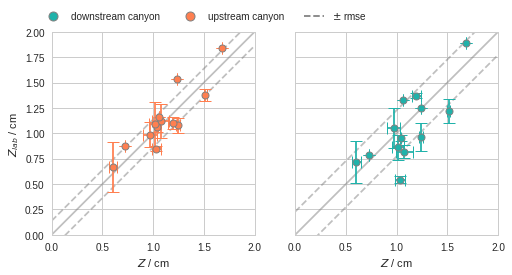

In [23]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)

rho0 = 998.5
g = 9.81
W = 0.05 # m
L = 0.12 # m

Z_list1 = []
Z_list2 = []
Z_HA2013_list = []

for exp, kk in zip(exp_dicts, range(exp_num)):
    delta_rho1 = np.zeros(len(exp['run_files']))
    delta_rho2 = np.zeros(len(exp['run_files']))
    N = np.ones(len(exp['run_files']))*np.nan
    Z_HA2013 = np.zeros(len(exp['run_files']))
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        inertial_period = 1/((exp["fo"])/(2*np.pi))
        win = int(inertial_period/dt)
        
        delta_rho2[ii] = 1000*(np.max(ctools.filter_timeseries(dens2[0:2400]-dens2[0],winlen=win))) # kg/m^3
        delta_rho1[ii] = 1000*(np.max(ctools.filter_timeseries(dens1[0:2400]-dens1[0],winlen=win))) # kg/m^3
        if np.isnan(exp["rho_sb"][ii])==True:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii-1]-1000*exp["rho_top"][ii-1])/(exp["hsb"]*0.01)))**0.5
        else:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
    
        f = exp["fo"] # rad/s
        U = exp["U"]/100 # m/s
        Hs = exp["hsb"]/100 # m
        s = (0.029-0.005)/(0.215) # (Hsb-Hcoast)/(dist coast to sb) = 0.112
        Dh = (f*L)/N[ii]
        Rw = U/(f*W)
        Rl = U/(f*L)
        Fw = Rw/(0.9+Rw)
        Se = (s*N[ii])/(f*((Fw/Rl)**0.5))
        Z_HA2013[ii] = Dh*((1.8*((Fw*Rl)**0.5)*(1-0.42*Se))+0.05)
    
    Z_HA = np.nanmean(Z_HA2013)*100
    stdHA = np.nanstd(Z_HA2013)*100
    Z1 = np.nanmean(100*(g/rho0)*(delta_rho1/N**2)) #cm
    Z2 = np.nanmean(100*(g/rho0)*(delta_rho2/N**2)) #cm
    std1 = np.nanstd(100*(g/rho0)*(delta_rho1/N**2)) #cm
    std2 = np.nanstd(100*(g/rho0)*(delta_rho2/N**2)) #cm
    
    
    Z_list1.append(Z1)
    Z_list2.append(Z2)
    Z_HA2013_list.append(Z_HA)
    
    sca = ax1.errorbar(Z_HA,Z1,yerr=std1,xerr=stdHA,
                       marker='o',color='coral', 
                       markeredgecolor='0.5', 
                       markeredgewidth=1,capsize=6) 
    sca2 = ax2.errorbar(Z_HA,Z2,yerr=std2,xerr=stdHA,
                        marker='o',color='lightseagreen',
                        markeredgecolor='0.5',
                        markeredgewidth=1,capsize=6) 

rmse1 = (mean_squared_error(Z_HA2013_list, Z_list1))**0.5
rmse2 = (mean_squared_error(Z_HA2013_list, Z_list2))**0.5
print('the rmse1 is %f' %rmse1)        
print('the rmse2 is %f' %rmse2)        
        
legend_elements = [Line2D([0], [0], marker='o', color='w', label='downstream canyon',
                          markerfacecolor='lightseagreen',markeredgecolor='0.5',markeredgewidth=1,
                          markersize=9),
                   Line2D([0], [0], marker='o', color='w', label='upstream canyon',
                          markerfacecolor='coral',markeredgecolor='0.5',markeredgewidth=1,
                          markersize=9),
                   Line2D([0], [0], linestyle='--',color='0.5', label='$\pm$ rmse'),
                   ]
ax2.legend(handles=legend_elements,ncol=3, bbox_to_anchor=(0.4,1.15))
ax1.set_xlabel('$Z$ / cm')
ax2.set_xlabel('$Z$ / cm')
ax1.set_ylabel(r'$Z_{lab}$ / cm')
ax1.set_xlim(0,2)
ax1.set_ylim(0,2)
ax1.set_aspect(1)
ax2.set_xlim(0,2)
ax2.set_ylim(0,2)
ax2.set_aspect(1)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20), '-', color='0.5', alpha = 0.5,zorder=1)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20)+rmse1, '--', color='0.5', alpha = 0.5,zorder=1)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20)-rmse1, '--', color='0.5', alpha = 0.5,zorder=1)
ax2.plot(np.linspace(0,2,20),np.linspace(0,2,20), '-', color='0.5', alpha = 0.5,zorder=1)
ax2.plot(np.linspace(0,2,20),np.linspace(0,2,20)+rmse2, '--', color='0.5', alpha = 0.5,zorder=1)
ax2.plot(np.linspace(0,2,20),np.linspace(0,2,20)-rmse2, '--', color='0.5', alpha = 0.5,zorder=1)
plt.savefig('figures/Z_vs_Z_HA2013_twocan_std.eps', format='eps', transparent=False, bbox_inches='tight')

the rmse1 is 0.154193
the rmse2 is 0.264457


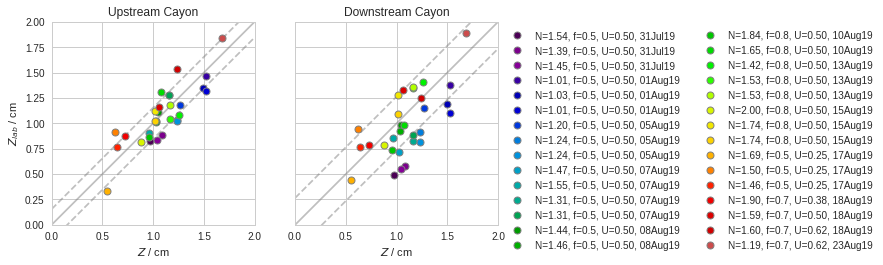

In [25]:
## RUN CELL TWICE
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)

rho0 = 998.5
g = 9.81
W = 0.05 # m
L = 0.12 # m

Z_list1 = []
Z_list2 = []
Z_HA2013_list = []

#sns.set_palette(sns.cubehelix_palette(12, start=.5, rot=-.95))
sns.set_palette('nipy_spectral',30)

for exp, kk in zip(exp_dicts, range(exp_num)):
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        
        if np.isnan(exp["rho_sb"][ii])==True:
            N =((g/rho0)*((1000*exp["rho_sb"][ii-1]-1000*exp["rho_top"][ii-1])/(exp["hsb"]*0.01)))**0.5
        else:
            N =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
        
        f = exp["fo"] # rad/s
        U = exp["U"]/100 # m/s
        Hs = exp["hsb"]/100 # m
        s = (0.029-0.005)/(0.215) # (Hsb-Hcoast)/(dist coast to sb) = 0.112
        Dh = (f*L)/N
        Rw = U/(f*W)
        Rl = U/(f*L)
        Fw = Rw/(0.9+Rw)
        Se = (s*N)/(f*((Fw/Rl)**0.5))
        Z_HA2013 = Dh*((1.8*((Fw*Rl)**0.5)*(1-0.42*Se))+0.05)
        
        inertial_period = 1/((exp["fo"])/(2*np.pi))
        win = int(inertial_period/dt)
        delta_rho2 = 1000*(np.max(ctools.filter_timeseries(dens2[0:2400]-dens2[0],winlen=win))) # kg/m^3
        delta_rho1 = 1000*(np.max(ctools.filter_timeseries(dens1[0:2400]-dens1[0],winlen=win))) # kg/m^3
        
        Z1 = (g/rho0)*(delta_rho1/N**2) #cm
        Z2 = (g/rho0)*(delta_rho2/N**2) #cm
        
        Z_list1.append(Z1*100)
        Z_list2.append(Z2*100)
        Z_HA2013_list.append(Z_HA2013*100)
        
        sca = ax1.plot(Z_HA2013*100,Z1*100,
                       'o', markeredgecolor='0.5', markeredgewidth=1, 
                       ) 
        
        sca = ax2.plot(Z_HA2013*100,Z2*100,
                       'o', markeredgecolor='0.5', markeredgewidth=1,
                      label='N=%1.2f, f=%1.1f, U=%1.2f, %s' %(N,exp["fo"],exp["U"], exp["date"])) 
        
rmse1 = (mean_squared_error(Z_HA2013_list, Z_list1))**0.5
rmse2 = (mean_squared_error(Z_HA2013_list, Z_list2))**0.5
print('the rmse1 is %f' %rmse1)        
print('the rmse2 is %f' %rmse2)        

ax1.set_xlabel('$Z$ / cm')
ax2.set_xlabel('$Z$ / cm')
ax1.set_ylabel(r'$Z_{lab}$ / cm')
ax1.set_xlim(0,2)
ax1.set_ylim(0,2)
ax1.set_aspect(1)
ax2.set_xlim(0,2)
ax2.set_ylim(0,2)
ax2.set_aspect(1)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20), '-', color='0.5', alpha = 0.5,zorder=1)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20)+rmse1, '--', color='0.5', alpha = 0.5,zorder=1)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20)-rmse1, '--', color='0.5', alpha = 0.5,zorder=1)
ax2.plot(np.linspace(0,2,20),np.linspace(0,2,20), '-', color='0.5', alpha = 0.5,zorder=1)
ax2.plot(np.linspace(0,2,20),np.linspace(0,2,20)+rmse2, '--', color='0.5', alpha = 0.5,zorder=1)
ax2.plot(np.linspace(0,2,20),np.linspace(0,2,20)-rmse2, '--', color='0.5', alpha = 0.5,zorder=1)
ax1.set_title('Upstream Cayon')
ax2.set_title('Downstream Cayon')
ax2.legend(ncol=2,bbox_to_anchor=(1,1))

### Downstream canyon

** Runs that fall below rmse line are:**
    
    Lowest (3 purplish points): f=0.5 rad/s, N=1.39-1.54 1/s, U=0.5 cm/s (Jul, 31st, runs 1, 2 ,3)

    Low top (2 dark blue points): f=0.5 rad/s, N=1.01-1.03 1/s, U=0.5 cm/s (Aug 1st, runs 2 and 3)

    Middle (2 blue points): f=0.5 rad/s, N=1.24 1/s, u=0.5 cm/s (August 5 runs 2, 3)

    Middle (3 green-blue points): f=0.5 rad/s, N=1.31 1/s, u=0.5 cm/s (August 7 runs 1, 3, 4)


** Runs above rmse line:**

    (1 orange point): f=0.5 rad/s, N=1.50 1/s, u=0.25 cm/s (August 17 run 2)
    
### Upstream canyon

**Runs that below rmse line - all very close to line:**
    
    3 purplish points: f=0.5 rad/s, N=1.39-1.54 1/s, U=0.5 cm/s (Jul, 31st, runs 1, 2 ,3)
    
    1 dark blue point: f=0.5 rad/s, N=1.01-1.03 1/s, U=0.5 cm/s (Aug 1st, runs 3)
    
    1 blue points: f=0.5 rad/s, N=1.24 1/s, u=0.5 cm/s (August 5, run 3)
    
    1 yellow point: 1 orange point: f=0.5 rad/s, N=1.69 1/s, u=0.25 cm/s (August 17 run 1)
 
 
**Runs above rmse line:**

    1 orange point: f=0.5 rad/s, N=1.50 1/s, u=0.25 cm/s (August 17 run 2)
    
    1 red point: f=0.7 rad/s, N=1.60 1/s, u=0.62 cm/s (August 18 run 3)
    

Runs that are **consistently low** in both canyons are July 31st (all runs); August 1st, run 3; August 5, run 3. Runs **consistently high** are August 17, run 2.

In [34]:
15/0.5

30.0

In [20]:
15/2.9

5.172413793103448